## Reproducing phase/orbit diagram of Van der Pol oscillator

1. Create the vector field of Van der Pol oscillator on a $m\times m$ mesh
2. train a 2 hidden layer(around 20 nodes each) FFW network with the vector field for  $\textit{epochs}\simeq20000$ (or more)
3. $\textbf{Choice of activation function matters a lot:}$ Here I used $Sigmoid()$ function and adjusted it to work for both positive and negative values. Changed the working range between $[-30:30]$ because at the edges of mesh (or too far from the trajectory) the vector field is too steep or changes fast with higher derivative values as it tries to take the system towards the stable orbit as fast as possible. 
    
    * Also, I parameterized $Sigmoid()$ function to slow it down by using $exp(-c*x)$ with $c\leq1$ (here $c=0.15$ fits best), reason to make it slower is that $Sigmoid()$ function quickly settles at extreme values i.e -1 or 1 (for general $Sigmoid()$ function) giving less opportunity for intermediate points $\simeq0$ to settle the system there. 
    
    * Too small $c$ will make the $Sigmoid()$ function to act as a linear function, which is not good for the backpropagation as derivative of linear function is just $1$. 

    * $\textbf{NOTE:}$ Important is the choice of $\eta$ (eta) and nodes in hidden layer which should not be too less or too more; also $\textit{m}$ should not be too large or otherwise it will take the trained trajectory to some fixed point  

### Changes to improve accuracy in Orbit learning:

1. first decrease the meash grid, as they are not so necessary ($m = 5$ works fine)
2. create vector field around the teacher trajectory with some $radius$
3. join (1) and (2); i.e vector field of both mesh grid and extra points around the trajectory.
4. decrease the influence of mesh grid poiints as they are not so important, they are required to give initial trasients to show direction towards the real orbit; so while joining (1) and (2) multiply vector field of (1) by mesh-influence factor ($\texttt{mesh_inf}$)
5. train it and while testing; add a $\texttt{point-momentum}$ factor while updating the new point  


6. $\underline{\textbf{Best parameters found:}}$ (weights) momentum = 0.9999, $(\eta)eta = 0.0000001$, b1 = 0.01, b2 = 0.01, $\texttt{b_out}$ = 0.01, L1 and L2 = 20, epochs = 40000, $radius = 0.2$, $\texttt{mesh_inf} = 0.8$, $\texttt{point-momentum} = 0.01$

In [21]:
import numpy as np
import random
import math
from scipy.spatial import distance
import time
from tqdm.notebook import tqdm, trange
#random.seed(1)

def lin_fun(x):
    return x

def lin_derivative(x):
    return 1

def sigmoid_fun(x):
    return 60/(1+ np.exp(-c*x)) -30

def sigmoid_derivative(x):
    return 60*c*np.exp(-c*x)/(1 + np.exp(-c*x))**2 

#def sigmoid_derivative(x):
#    return (x)*(1.0 - (x))

c = 0.15

def tanh_fun(x):
    #return 2/(1 + np.exp(-2*x)) - 1.0
    return 4*np.tanh(x)

def tanh_derivative(x):
    return 4*(1 - np.tanh(x)**2)


def linear_fun(x):
    return x

def linear_derivative(x):
    return 1


class NeuralNetwork:
    def __init__(self, x, y, b1, b2, b_out, L1nodes, L2nodes, W1, W2, W3):
        self.input      = x
        self.weights1   = W1
        self.weights2   = W2            
        self.y          = y
        self.weights3   = W3
        self.output     = np.zeros(self.y.shape)
        
       
    def feedforward(self):
        self.layer1 = sigmoid_fun(np.dot(self.input, self.weights1) + b1)
        self.layer2 = sigmoid_fun(np.dot(self.layer1, self.weights2) + b2)
        self.output = sigmoid_fun(np.dot(self.layer2, self.weights3) + b_out)

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights3 = np.dot(self.layer2.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        
        d_weights2 = np.dot(self.layer1.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights3.T) * sigmoid_derivative(self.layer2)))
        
        d_weights1 = np.dot(self.input.T, (np.dot(np.dot(2*(self.y - self.output) *sigmoid_derivative(self.output), self.weights3.T) * sigmoid_derivative(self.layer2)  , self.weights2.T) ) * sigmoid_derivative(self.layer1))   

        
        # update the weights with the derivative (slope) of the loss function
        holdwghts1 = momentum*self.weights1 + eta*d_weights1
        holdwghts2 = momentum*self.weights2 + eta*d_weights2
        holdwghts3 = momentum*self.weights3 + eta*d_weights3
        
        self.weights1 = holdwghts1
        self.weights2 = holdwghts2
        self.weights3 = holdwghts3
        

# NN quick test

In [4]:
L1 = 3; L2 = 5;
b1 = 0.01; b2 = 0.01; b_out = 0.01
momentum = 1;  eta = 0.001

X = np.array([[-1.54,2.84,3.41],
         [3.76,-0.15,-2.81],
         [2.64,-2.95,0.21],
         [-3.72,3.35,-1.51]])
y = np.array([[-3.57,0.88],[-2.17,-1.61],[2.51,3.25],[-0.41,2.28]])

Wght1 = np.random.rand(X.shape[1],L1) 
Wght2 = np.random.rand(L1,L2) 
Wght3 = np.random.rand(L2, y.shape[1])

if __name__ == "__main__":
    nn = NeuralNetwork(X,y,b1,b2,b_out,L1,L2, Wght1, Wght2, Wght3)

    for i in range(8000):
        nn.feedforward()
        nn.backprop()

    print(nn.output)

[[-4.84069213 -0.38915063]
 [-1.82493414 -1.83417345]
 [ 2.43259253  0.29803464]
 [-0.77832477  0.11926608]]


# Van der Pol oscillator

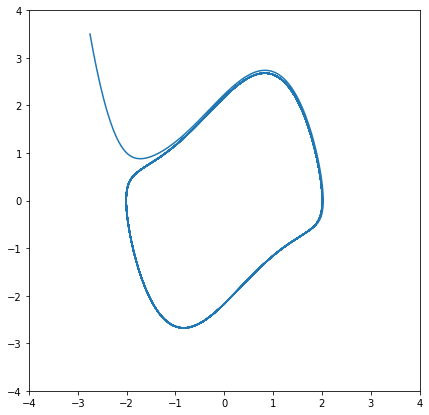

In [7]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

def van_der_pol(z, t, alpha, b, omega):
    x = z[0]
    y = z[1]
    dxdt = y
    dydt = -alpha*(x*x - b)*y - x*omega**2
    dzdt = [dxdt,dydt]
    return dzdt

alpha = 1; b = 1; omega = 1
z0 = [-2.75,3.5]
n = 5000
t = np.linspace(0,100,n)
sol = odeint(van_der_pol, z0, t, args=(alpha, b, omega))

######################################################
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 7
fig_size[1] = 7  
plt.rcParams["figure.figsize"] = fig_size  

plt.plot(sol[0:,0], sol[0:,1])
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()

In [8]:
alpha = 1; b = 1; omega = 1
m = 5

def Vector_field_VanDerPol():
    X, Y = np.meshgrid(np.linspace(-3,3,m),np.linspace(-3,3,m))
    Vx = []; Vy = []

    for i in range(m):
        for j in range(m):
            z0 = [X[i][j],Y[i][j]]
            dzdt = van_der_pol(z0, -1, alpha, b, omega)
            Vx.append(dzdt[0])
            Vy.append(dzdt[1])
        
    Vxn = np.reshape(Vx, (-1, m))
    Vyn = np.reshape(Vy, (-1, m))

    Xn = np.reshape(X, (-1, 1))
    Yn = np.reshape(Y, (-1, 1))
    
    return X, Y, Xn, Yn, Vx, Vy, Vxn, Vyn 

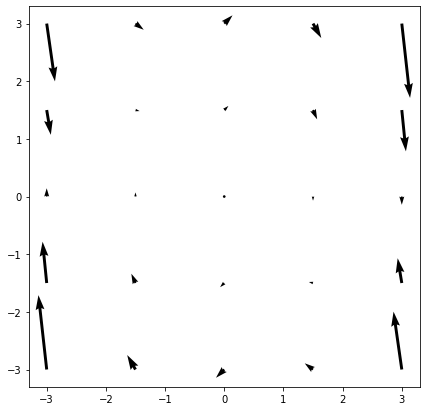

In [10]:
X1, Y1, Xn1, Yn1, Vx1, Vy1, Vxn1, Vyn1 = Vector_field_VanDerPol()

fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 7
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size 

plt.quiver(X1, Y1, Vxn1, Vyn1) 
plt.show()

In [11]:
momentum = 0.99999;  eta = 0.0000001
b1 = 0.01; b2 = 0.01; b_out = 0.01

L1nodes = 16
L2nodes = 16

epochs = 5000

X_input = np.array([]); X_output = np.array([])
for i in range(len(Vx1)):
    X_input = np.append(X_input, [Xn1[i][0], Yn1[i][0]])
    X_output = np.append(X_output, [Vx1[i], Vy1[i]])

X_in = np.reshape(X_input,(-1,2))    
X_out = np.reshape(X_output,(-1,2))

Wght1 = np.random.rand(X_in.shape[1],L1nodes) 
Wght2 = np.random.rand(L1nodes,L2nodes) 
Wght3 = np.random.rand(L2nodes, X_out.shape[1])

if __name__ == "__main__":
    
    nn = NeuralNetwork(X_in, X_out, b1, b2, b_out, L1nodes, L2nodes, Wght1, Wght2, Wght3)
    for i in range(epochs):        
        nn.feedforward()
        nn.backprop()
         
#     print(nn.output)

In [12]:
# X_out

In [13]:
x0 = -2.0; y0 = -3.0

X_test = np.array([[x0,y0]])
fake_out = np.array([[0.01,0.01]])

Wght1 = nn.weights1
Wght2 = nn.weights2
Wght3 = nn.weights3

Trajectory = np.array([X_test[0][0],X_test[0][1]])

if __name__ == "__main__":
    
    for i in range(epochs):        
        nn1 = NeuralNetwork(X_test, fake_out, b1, b2, b_out, L1nodes, L2nodes, Wght1, Wght2, Wght3)
        nn1.feedforward()
        X_test = X_test + 0.01*nn1.output
        #X_test = nn1.output
        Trajectory = np.append(Trajectory,[X_test[0][0],X_test[0][1]])

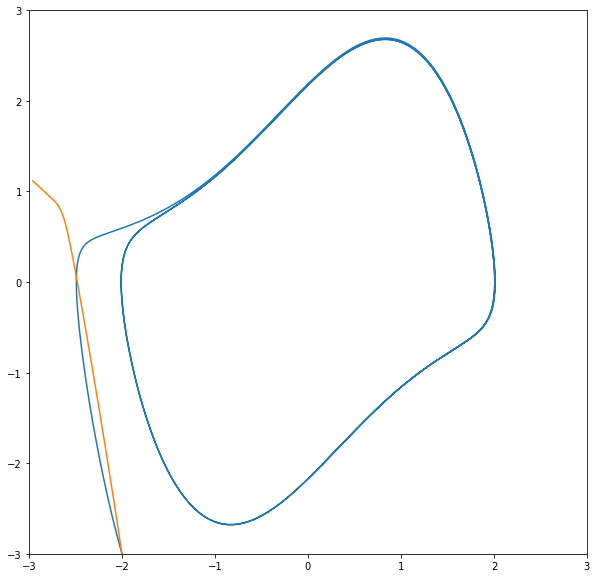

In [29]:
alpha = 1; b = 1; omega = 1
n = 1000
t = np.linspace(0,20,n)
z0 = [x0,y0]
sol = odeint(van_der_pol, z0, t, args=(alpha, b, omega))

plt.plot(sol[0:,0], sol[0:,1])
plt.xlim(-1,1)
plt.ylim(-1,1)

fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 7
fig_size[1] = 7 
plt.rcParams["figure.figsize"] = fig_size  


tar = np.reshape(Trajectory,(-1,2))
tt = np.linspace(0,len(tar), len(tar))
plt.plot(tar[:,0],tar[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [65]:
def Nearby_Orbit_Points(radius):
    alpha = 1; b = 1; omega = 1
    z0 = [-2.75,3.5]
    n = 10000
    t = np.linspace(0,400,n)
    sol = odeint(van_der_pol, z0, t, args=(alpha, b, omega))
    orbit = sol[9800:10000]
    
    #if radius==0:
    Nearby_pts_unique = sol[9000:]
        #return Nearby_pts_unique

    uni = np.random.randint(-300,300, size=(15000,1,2))/100

    Nearby_pts = np.array([])
    for i in trange(len(uni)):
        for j in range(len(orbit)):
            a = (uni[i][0][0], uni[i][0][1])
            b = (orbit[j][0], orbit[j][1])
            dst = distance.euclidean(a,b)
            if dst< radius:
                Nearby_pts = np.append(Nearby_pts, a)
                j = 10**8

    Nearby_pts_all = np.reshape(Nearby_pts,(-1,2))
    Nearby_pts_unique1 = np.append(Nearby_pts_unique, np.unique(Nearby_pts_all, axis=0), axis=0)
    #Nearby_pts_unique1 = np.unique(Nearby_pts_all, axis=0)
    return Nearby_pts_unique1

  0%|          | 0/15000 [00:00<?, ?it/s]

Wall time: 49.1 s


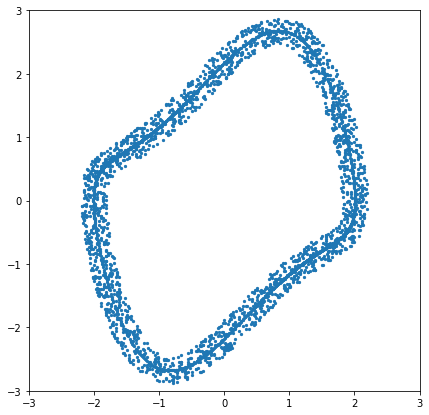

In [66]:
radius = 0.2
%time More_pts = Nearby_Orbit_Points(radius)

############################################
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 7
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size  

plt.scatter(More_pts[:,0], More_pts[:,1], s=5)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [67]:
More_pts.shape
#np.random.randint(2000,10000, size=(1000,))

(3183, 2)

In [68]:
for i in range(100):
    if i*i > len(More_pts):
        least_sq_no = i-1
        extra_pts = len(More_pts) - (i-1)**2
        break
extra_pts

47

In [69]:
More_pts1 = More_pts[extra_pts:]
len(More_pts1)

Vx_more = []; Vy_more = []
for i in trange(len(More_pts1)):
    z0 = [More_pts1[i][0],More_pts1[i][1]]
    dzdt = van_der_pol(z0, -1, alpha, b, omega)
    Vx_more.append(dzdt[0])
    Vy_more.append(dzdt[1])

  0%|          | 0/3136 [00:00<?, ?it/s]

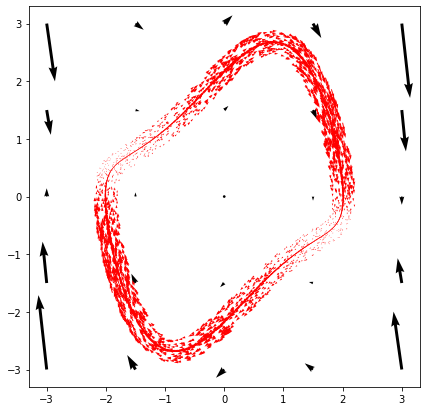

In [75]:
X1, Y1, Xn1, Yn1, Vx1, Vy1, Vxn1, Vyn1 = Vector_field_VanDerPol()

Vx_more1 = np.reshape(Vx_more,(-1,least_sq_no))
Vy_more1 = np.reshape(Vy_more,(-1,least_sq_no))

More_x = np.reshape(More_pts1[:,0],(-1,least_sq_no))
More_y = np.reshape(More_pts1[:,1],(-1,least_sq_no))

########################################################
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 7
fig_size[1] = 7  
plt.rcParams["figure.figsize"] = fig_size  

plt.quiver(X1, Y1, Vxn1, Vyn1)
plt.quiver(More_x, More_y, Vx_more1, Vy_more1, linewidth=0.5, color='r')

# plt.savefig('Vectorfield.png')
plt.show()

In [41]:
# del X_in_new; del X_out_new;
mesh_inf = 0.8

X_in_new = np.append(X_in, More_pts1, axis=0)
#X_in_new = More_pts1
Voutn = (np.array([Vx_more, Vy_more])).T
X_out_new = np.append(X_out*mesh_inf, Voutn, axis=0)   # appending new orbit points over the mesh vector field 
                                                  # decreasing the influence of mesh vetors on weights by multiplying it by a factor
#X_out_new = Voutn

# Training 2 layer NN 

In [39]:
momentum = 0.9999;  eta = 0.0000001
b1 = 0.0; b2 = 0.0; b_out = 0.0

L1nodes = 20
L2nodes = 20

epochs = 40000

Wght1n = np.random.rand(X_in_new.shape[1],L1nodes) 
Wght2n = np.random.rand(L1nodes,L2nodes) 
Wght3n = np.random.rand(L2nodes, X_out_new.shape[1])

if __name__ == "__main__":
    
    nn_new = NeuralNetwork(X_in_new, X_out_new, b1, b2, b_out, L1nodes, L2nodes, Wght1n, Wght2n, Wght3n)
    for i in trange(epochs):        
        nn_new.feedforward()
        nn_new.backprop()
         
    print(nn_new.output)

  0%|          | 0/40000 [00:00<?, ?it/s]

[[-2.69726125 14.77827328]
 [-2.86023982  4.14202633]
 [-2.92443843 -3.05003987]
 ...
 [-0.15989394 -1.48604351]
 [ 0.1161918  -2.42156996]
 [ 0.0274066  -2.12443529]]


In [42]:
X_out_new.shape

(3274, 2)

# Generating trajectory from intial point [x0, y0]

In [43]:
x0 = -3; y0 = 2
point_momnetum = 0.01

X_test1 = np.array([[x0,y0]])
fake_out1 = np.array([[0.01,0.01]])

Wght1n = nn_new.weights1
Wght2n = nn_new.weights2
Wght3n = nn_new.weights3

Trajectory1 = np.array([X_test1[0][0],X_test1[0][1]])

if __name__ == "__main__":
    
    for i in trange(epochs):        
        nn_new1 = NeuralNetwork(X_test1, fake_out1, b1, b2, b_out, L1nodes, L2nodes, Wght1n, Wght2n, Wght3n)
        nn_new1.feedforward()
        X_test1 = X_test1 + point_momnetum*nn_new1.output
        #X_test = nn1.output
        Trajectory1 = np.append(Trajectory1,[X_test1[0][0],X_test1[0][1]])

  0%|          | 0/40000 [00:00<?, ?it/s]

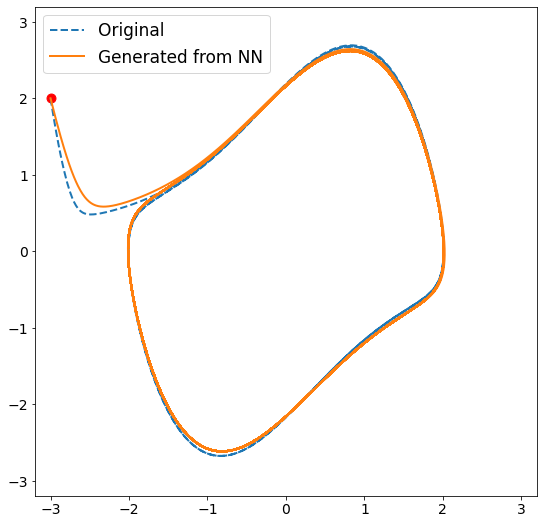

In [61]:
alpha = 1; b = 1; omega = 1
n = 1000
t = np.linspace(0,20,n)
z0 = [x0,y0]

sol1 = odeint(van_der_pol, z0, t, args=(alpha, b, omega))

tar1 = np.reshape(Trajectory1,(-1,2))

####################################################
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 9
fig_size[1] = 9  
plt.rcParams["figure.figsize"] = fig_size  

plt.scatter(x0, y0, s=80, color='r')
plt.plot(sol1[0:,0], sol1[0:,1], lw=2, ls='--', label='Original')
plt.plot(tar1[:,0],tar1[:,1], lw=2, label='Generated from NN')

plt.legend(loc='best', fontsize=17)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# plt.savefig('TrjGen.png')
plt.show()